# Steps for Execution



1. Place the following files in "code\input" folder
  *   train.csv
  *   test.csv
  *   dataset.zip - all images in it
2. Update PATH_TO_CODE_FOLDER in "Inputs and hyperparameters" section.
3. Run all the cells, if this code is executed in colab.
4. Run all the cells except "Mount Google Drive", if this code is executed in not colab.

Irrespective of the number of epochs the code will save and use the weights for one with highest validation f1-score.



# Import Libraries

In [1]:
# Data process
import pandas as pd
import numpy as np

# Graphing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Image loading
from PIL import Image
import glob
from numpy import asarray

# Output
from sys import stdout
import csv
import copy
from random import seed
from random import randint
import random
import time
import datetime
import zipfile
#from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
from skimage.transform import rotate
from skimage.util import random_noise
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Mount Goole Drive (only for colab)

Please execute this cell only for google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Inputs and hyper parameters

In [0]:
PATH_TO_CODE_FOLDER = "/content/drive/My Drive/Code"
VALIDATION_SET_SIZE = 0.10

#CNN inputs
CNN_BATCH_SIZE = 128
CNN_EPOCHS = 15
CNN_LEARNING_RATE = 0.0001 #0.0001

#BILSTM inputs
BILSTM_HIDDEN_DIM = 50
BILSTM_EPOCHS = 200
BILSTM_LEARNINGRATE=0.02
BITSTM_BATCHSIZE = 250

#Combined NN inputs
BATCHSIZE_COMBINEDNN= 1000
EPOCH_COMBINEDNN = 80
HIDDEN_COMBINEDNN = 2000
LEARNINGRATE_COMBINEDNN = 0.02
PATIENCE = 2

In [4]:
pd.set_option('display.max_colwidth', -1)
if (not PATH_TO_CODE_FOLDER.endswith('/')):
    PATH_TO_CODE_FOLDER+="/"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# Load Dataset

## Load Training Data

In [5]:
train_file = open(PATH_TO_CODE_FOLDER+'input/train.csv',"r+").read()
colnames = train_file.split("\n")[0]

traindata_lines =  train_file.split(colnames)[1].split("\"\n")
train=pd.DataFrame(columns=colnames.split(","))

print("Loading training data.")
for idx in  tqdm(range(len(traindata_lines))):
    if traindata_lines[idx].strip() == "":
        continue
    templist = []
    try:
        index1 = traindata_lines[idx].index(",")
        index2 = traindata_lines[idx].index(",\"")
    except:
        print("skipping",traindata_lines[idx])
    templist.append(traindata_lines[idx][0:index1].strip())
    templist.append(traindata_lines[idx][index1+1:index2])
    templist.append(traindata_lines[idx][index2+1:len(traindata_lines)].strip("\""))
    train.loc[len(train)]=templist


  0%|          | 53/30001 [00:00<01:54, 261.10it/s]

Loading training data.


100%|██████████| 30001/30001 [02:15<00:00, 221.88it/s]


## Load Test Data

In [6]:
test_file = open(PATH_TO_CODE_FOLDER+'input/test.csv',"r+")  
  
testdata_lines =  test_file.read().split("\n")


test=pd.DataFrame(columns=testdata_lines[0].split(","))

print("Loading test data.")
for i in tqdm(range(1,len(testdata_lines))):
    if testdata_lines[i].strip() == "":
        continue
    templist = []
    eachline = testdata_lines[i].split(",\"")
    try:
        templist.append(eachline[0].strip())
        templist.append(eachline[1].strip("\""))
    except:
        print(eachline)
    test.loc[len(test)]=templist
    

  0%|          | 26/10001 [00:00<00:40, 248.82it/s]

Loading test data.


100%|██████████| 10001/10001 [00:35<00:00, 280.15it/s]


## Load Images

In [7]:
print("Loading images: ")

image_dict = {} # Stores values with the filename as the key


with zipfile.ZipFile(PATH_TO_CODE_FOLDER+'input/dataset.zip') as archive:
    images_len = len(archive.infolist())
    #print(images_len)
    images_load = images_len/100
    load_count = 0 # 1-100
    image_count = 0 # 1-40,000
    for entry in tqdm(archive.infolist()):
        if entry.filename.lower().endswith(".jpg"):            
            with archive.open(entry) as file:
                #print(file)
                pic = Image.open(file)
                #print(img.size, img.mode, len(img.getdata()))
                pic_values = asarray(pic) # convert image to array of values
                tempname = entry.filename.replace("/","\\").split("\\")
                key = tempname[len(tempname)-1]
                image_dict[key] = pic_values
                #if (image_count % images_load == 0):
                #    load_count += 1
                #    stdout.write("\r%d" % load_count)
                #    stdout.write("%")
                #   stdout.flush()
                image_count += 1

print("\nImages loaded :",len(image_dict))

Loading images: 


100%|██████████| 40002/40002 [01:22<00:00, 484.12it/s]


Images loaded : 40000


# CNN - Preparation and Training

## Training and Validation Split

In [8]:

from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(train, test_size=VALIDATION_SET_SIZE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Validation_Data Length: {len(val_df)}\nTrain_Data Length: {len(train_df)}")

Validation_Data Length: 3000
Train_Data Length: 27000


## Image Transformations

In [0]:
data_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),   
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
       
    ])

data_test_transforms = transforms.Compose([
        #transforms.Resize(256),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

## Label preprocessing

In [10]:
all_single_labels= []
all_single_labels += [int(x) for lst in [eachlab.split(" ") for eachlab in train.Labels] for x in lst] 
unique_labels = np.unique(all_single_labels)
print(unique_labels)
#print(len(unique_labels))

#output_dim =max(unique_labels)+1
#print(output_dim)

label_to_index = {n: i for i, n in enumerate(unique_labels)}
index_to_label = {i: n for i, n in enumerate(unique_labels)}
#print(index_to_label)
#print(label_to_index)
output_dim = len(label_to_index)
print("Number of unique labels :",output_dim)

[ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19]
Number of unique labels : 18


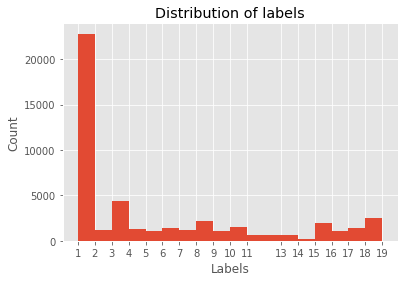

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.hist(all_single_labels,bins=unique_labels)
plt.title("Distribution of labels")
plt.ylabel('Count')
plt.xlabel('Labels')
plt.xticks(unique_labels)
plt.show()

In [0]:
seed=27

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Custom Image Dataset

In [0]:


from torch.utils import data
class ImageData(data.Dataset):
    def __init__(self,df,transform,test = False):
        self.df = df
        self.test = test
        self.conv_to_tensor = transform
        self.image_arr = self.df.iloc[:, 0] #File Name of images
        if not self.test:  #No labels for test data
             self.label_df = self.df.iloc[:,1]
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img_tensor = self.conv_to_tensor(Image.fromarray(image_dict[image_name])) 
        if not self.test: #Return labels for non test data
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, label_to_index[int(label)]] = 1  #converting lavel to index of label
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)



## Dataloaders

In [0]:


# Train dataset
train_dataset = ImageData(train_df,data_transforms)
train_loader = data.DataLoader(dataset=train_dataset,batch_size=CNN_BATCH_SIZE,shuffle=True)


# validation dataset
val_dataset = ImageData(val_df,data_test_transforms)
val_loader = data.DataLoader(dataset=val_dataset,batch_size=CNN_BATCH_SIZE,shuffle=True)

#full dataset - to be used during feature extractions
full_dataset = ImageData(train,data_test_transforms)
full_loader = data.DataLoader(dataset=full_dataset,batch_size=250,shuffle=False)

# test dataset
test_dataset = ImageData(test,data_test_transforms,test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=CNN_BATCH_SIZE,shuffle=False)

## Model Build

In [15]:


resnet_cls = models.resnet50(pretrained=True, progress=True) #Load Pretrained ResNet50

#Convert activations of ResNet50 to LeakyReLU
resnet_cls.relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer1[0].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer1[1].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer1[2].relu = nn.LeakyReLU(inplace=True)

resnet_cls.layer2[0].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer2[1].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer2[2].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer2[3].relu = nn.LeakyReLU(inplace=True)

resnet_cls.layer3[0].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer3[1].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer3[2].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer3[3].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer3[4].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer3[5].relu = nn.LeakyReLU(inplace=True)


resnet_cls.layer4[0].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer4[1].relu = nn.LeakyReLU(inplace=True)
resnet_cls.layer4[2].relu = nn.LeakyReLU(inplace=True)

    
class ResNet50(nn.Module):
    def __init__(self,num_outputs):
        super(ResNet50,self).__init__()
        self.resnet = resnet_cls
         #Remove and manually add FC layers so that image features can be extracted after training
        self.resnet.fc = nn.Sequential() 
        self.linear = nn.Linear(2048, num_outputs,bias=True)
        
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
    def forward(self,x):
        resout = self.resnet(x)
        x = self.linear(resout)
        return F.sigmoid(x),resout
    
NeuralNet = ResNet50(num_outputs = output_dim) #Initialise model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Functions for Save and load check points

In case we want to train the model for future

In [0]:
#Code to save and load checkpoints to resume training the model in the future

import torch
import shutil
def save_ckp(state, is_best, checkpoint_name, best_model_name):
    f_path = checkpoint_name
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_name
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

#Sample code for calling loading and save check point functions.

#ckp_path = "/content/SeqCheckPoint_59.pt"  #Uncomment to load a check point 
#net, optimizer, start_epoch = load_ckp(ckp_path, net, optimizer) #Uncomment to load a check point


#Uncomment to save a check point
    #if epoch % 60 == 59:
    #  print("saving model check point")
    #  checkpoint = {
    #      'epoch': epoch + 1,
    #      'state_dict': net.state_dict(),
    #      'optimizer': optimizer.state_dict()
    #  }
    #  save_ckp(checkpoint, False, "/content/SeqCheckPoint_"+str(epoch)+".pt","/content/SeqCheckPoint_"+str(epoch)+".pt")  

In [0]:
import warnings
warnings.filterwarnings("ignore")


NeuralNet = NeuralNet.to(device)
optimizer = optim.Adam(NeuralNet.parameters(),lr = CNN_LEARNING_RATE, weight_decay=1e-5)
loss_func = torch.nn.BCELoss()
best_f1 = np.NINF
start_epoch = 0
train_loss = []
val_loss = []
val_fone=[]

## Load Pretrained Model (Optional)

In [0]:
path = PATH_TO_CODE_FOLDER+"algorithm/ImageClassification.pt"   #Load above saved model
try:
  NeuralNet = torch.load(path)
except:
  NeuralNet = torch.load(path, map_location=torch.device('cpu')) #Load into CPU if GPU is not available

## Training Model (Only for retraining)

Please only execute this section if you want to test with different hyperparameters, else the previously loaded model would suffice.

Training started @ 27-05-2020 07:56:11
Info : model f1-score Improved from -inf to 0.78072116
Epoch: 1/15 | Training loss:0.15939493 | Validation loss:0.10050909 | Validation f1:0.78072116 | Time: 411.4026s
Info : model f1-score Improved from 0.78072116 to 0.79981402
Epoch: 2/15 | Training loss:0.10944449 | Validation loss:0.09509540 | Validation f1:0.79981402 | Time: 410.4798s
Info : model f1-score Improved from 0.79981402 to 0.80709348
Epoch: 3/15 | Training loss:0.10291981 | Validation loss:0.09399580 | Validation f1:0.80709348 | Time: 409.9461s
Info : model f1-score Improved from 0.80709348 to 0.81867593
Epoch: 4/15 | Training loss:0.09971166 | Validation loss:0.09203316 | Validation f1:0.81867593 | Time: 409.7251s
Epoch: 5/15 | Training loss:0.09589934 | Validation loss:0.09383705 | Validation f1:0.81773783 | Time: 412.1034s
Epoch: 6/15 | Training loss:0.09316953 | Validation loss:0.09228894 | Validation f1:0.81562090 | Time: 410.8657s
Epoch: 7/15 | Training loss:0.09111124 | Vali

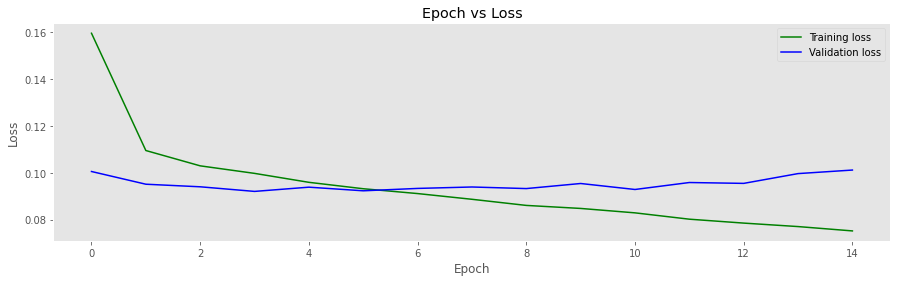

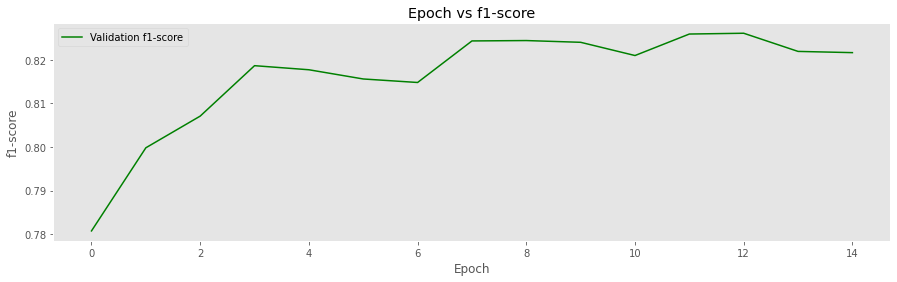

In [0]:


starttime = datetime.datetime.now()
print("Training started @ "+starttime.strftime("%d-%m-%Y %H:%M:%S"))

#Uncomment to load a check point
#NeuralNet, optimizer_tmp, start_epoch = load_ckp("/content/drive/My Drive/Code/algorithm/Checkpoint-16-05-2020-16-55.pt", NeuralNet, optimizer)


for epoch in range(start_epoch,CNN_EPOCHS):
        start_time = time.time()
        NeuralNet.train()
        running_loss = 0.0
        counter = 0
        prev_lr=0
        prev_loss = 0
        for idx1,(images_batch, labels_batch) in enumerate(train_loader):
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)            
            optimizer.zero_grad()            
            with torch.set_grad_enabled(True):
                pred_batch,_ = NeuralNet(images_batch)
                loss = loss_func(pred_batch,labels_batch)
            current_lr = optimizer.param_groups[0]['lr']
            loss.backward()
            optimizer.step()
            prev_lr = current_lr
            prev_loss = loss
            running_loss += loss.item() * images_batch.size(0)
            counter+=1
        trian_epoch_loss = running_loss / len(train_loader.dataset)
              
        NeuralNet.eval()
        running_loss = 0.0
        counter = 0
        all_output_labels = []
        all_preds = []
        for images_batch, labels_batch in val_loader:
            all_output_labels.extend(labels_batch.numpy().tolist())
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            optimizer.zero_grad()            
            with torch.set_grad_enabled(False):
                pred_batch,_ = NeuralNet(images_batch)
                all_preds.extend(torch.round(pred_batch).detach().cpu().numpy().tolist())
                loss = loss_func(pred_batch,labels_batch)    
            running_loss += loss.item() * images_batch.size(0)
            counter+=1
        val_epoch_loss = running_loss / len(val_loader.dataset)
        val_f1_score = f1_score(y_true=all_output_labels, y_pred=all_preds, average='samples')#cal_f1score(all_preds, all_output_labels)
        if val_f1_score > best_f1:            
            print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_f1_score))
            best_f1 = val_f1_score
            best_model_wts = copy.deepcopy(NeuralNet.state_dict())       
        elapsed_time = time.time()-start_time
        train_loss.append(trian_epoch_loss)
        val_loss.append(val_epoch_loss)
        val_fone.append(val_f1_score)
        print("Epoch: {}/{} | Training loss:{:.8f} | Validation loss:{:.8f} | Validation f1:{:.8f} | Time: {:.4f}s".format(epoch+1,
                                                                              CNN_EPOCHS,trian_epoch_loss,val_epoch_loss,val_f1_score,elapsed_time))
endtime = datetime.datetime.now()
print("Training ended @ "+endtime.strftime("%d-%m-%Y %H:%M:%S"))
print("Time taken for training :",endtime-starttime)

plt.figure(figsize=(15,4))
plt.plot(train_loss,label="Training loss",color="green")
plt.plot(val_loss,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(val_fone,label="Validation f1-score",color="green")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

NeuralNet.load_state_dict(best_model_wts)

## Extract Image Features

In [0]:

image_features = []
NeuralNet.eval()

for images_batch, labels_batch in full_loader:
  images_batch = images_batch.to(device)
  optimizer.zero_grad()
  with torch.set_grad_enabled(False):
    _,hstates = NeuralNet(images_batch)   #hstates contain features returned by CNN
  image_features.extend(hstates.detach().cpu().numpy())

image_features = np.array(image_features)

test_image_features = []
#NeuralNet.eval()

for images_batch in test_loader:
  images_batch = images_batch.to(device)
  optimizer.zero_grad()
  with torch.set_grad_enabled(False):
    _,hstates = NeuralNet(images_batch)
  test_image_features.extend(hstates.detach().cpu().numpy())
test_image_features = np.array(test_image_features)

# BiLSTM - Caption Preprocessing and Training

## Case Folding

In [0]:
caption_train = [s.lower() for s in train.Caption]
caption_test = [s.lower() for s in test.Caption]

## Handle Punctuation Marks

In [0]:
import re

def remove_punctuation_re(x):

    tempwords = x.split()
    bool_longword = False 
    for i in range(len(tempwords)):
      if len(tempwords[i]) > 20:      
        tempwords[i] = re.sub(r'[^\w\s]',' ',tempwords[i])
        if tempwords[i].count("_") > 1:  #Identifying multiple words which are seperated by _ and not by space. Example: - elizabeth_perkins_in_miracle_on
          tempwords[i] = tempwords[i].replace("_"," ")  
        bool_longword = True # Updating flag to join the modified words 
    if bool_longword == True:
      x = " ".join(tempwords)


    x = re.sub(r'[^\w\s]','',x)
    x = x.replace("½","")
    x = x.replace("¾","")
    x = x.replace("º","") 
    x = x.replace("ª","")
    x = x.replace(""," ")
    x = x.replace("³"," 3") 
    x = x.replace("1ç","1")
    x=x.replace("יגאל","")   
    return x

caption_train = [remove_punctuation_re(s) for s in caption_train]
caption_test = [remove_punctuation_re(s) for s in caption_test]

## Remove Digits

In [0]:
caption_train = [re.sub('\d+','', s) for s in caption_train]
caption_test = [re.sub('\d+','', s) for s in caption_test]

## Tokenize

In [23]:
import nltk
nltk.download('punkt')

from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

caption_train = [tknzr.tokenize(s) for s in caption_train]
caption_test  = [tknzr.tokenize(s) for s in caption_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Remove Stopwords

In [24]:
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stop_words = sw.words('english')  #Only English Stopwords


text_train_ns=[]
for tokens in caption_train:
  filtered_sentence = [w for w in tokens if not w in stop_words]
  text_train_ns.append(filtered_sentence)

text_test_ns=[]
for tokens in caption_test:
    filtered_sentence =  [w for w in tokens if not w in stop_words] 
    text_test_ns.append(filtered_sentence)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Lemmatization

In [25]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

text_train_le1 = []
for tokens in text_train_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_train_le1.append(lemma_sentence)

text_test_le1 = []
for tokens in text_test_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    text_test_le1.append(lemma_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
text_train_le=[]
for tokens in text_train_le1:
  filtered_sentence = [w for w in tokens if (not w.replace(" ","").isdecimal()) and ( w.count("_") != len(w))]  #We are removing tokens with only numbers and _
  text_train_le.append(filtered_sentence)

text_test_le=[]
for tokens in text_test_le1:
    filtered_sentence = [w for w in tokens if (not w.replace(" ","").isdecimal()) and ( w.count("_") != len(w))]
    text_test_le.append(filtered_sentence)

In [27]:
import copy
import datetime

#Adding all words into a list called word_sequence
word_sequence = []
for corpus_temp in [text_train_le,text_test_le]:
  for sentence in corpus_temp:
    word_sequence.extend(sentence)


print("Total unique words:",len(set(word_sequence)))

Total unique words: 6856


In [0]:
word_list = list(set(word_sequence))
#print(len(word_list))
word_list.sort()

# make dictionary so that we can reference each index of unique word during training
word_dict = {w: i for i, w in enumerate(word_list)}


## Word Embedding

In [29]:
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-100")

EMBEDDING_DIM = 100
unknown_words = 0
embedding_matrix = []
notknownword = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
        unknown_words=unknown_words+1
        notknownword.append(word)
embedding_matrix = np.array(embedding_matrix) #Save Embedding for each unique word
#embedding_matrix.shape

print("Number of unknown words:",unknown_words)

[==================================================] 100.0% 387.1/387.1MB downloaded
Number of unknown words: 459


## Caption Length Analysis

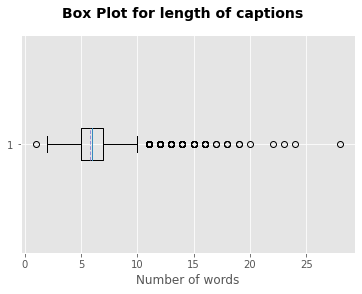

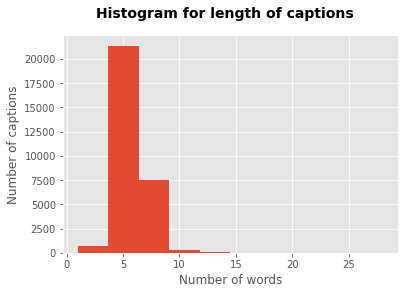


Maximum no. of words in captions : 28


In [30]:
import matplotlib.pyplot as plt
len_list = [len(s) for s in text_train_le]  #Storing length of reviews in training set.

#Creating a box plot for length of reviews
fig = plt.figure(1)
fig.suptitle('Box Plot for length of captions', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.boxplot(len_list,vert=False,meanline=True,showmeans=True)
ax.set_xlabel('Number of words')

#Creating a histogram for length of reviews
fig = plt.figure(2)
fig.suptitle('Histogram for length of captions', fontsize=14, fontweight='bold')
bx = fig.add_subplot(111)
bx.hist(len_list)
bx.set_xlabel('Number of words')
bx.set_ylabel('Number of captions')


plt.show()
print("\nMaximum no. of words in captions :",max(len_list))

#plt.hist(len_list)


Number of captions less than 4 words : 671
Number of captions less than 6 words : 13275
Number of captions less than 8 words : 26880
Number of captions less than 10 words : 29530


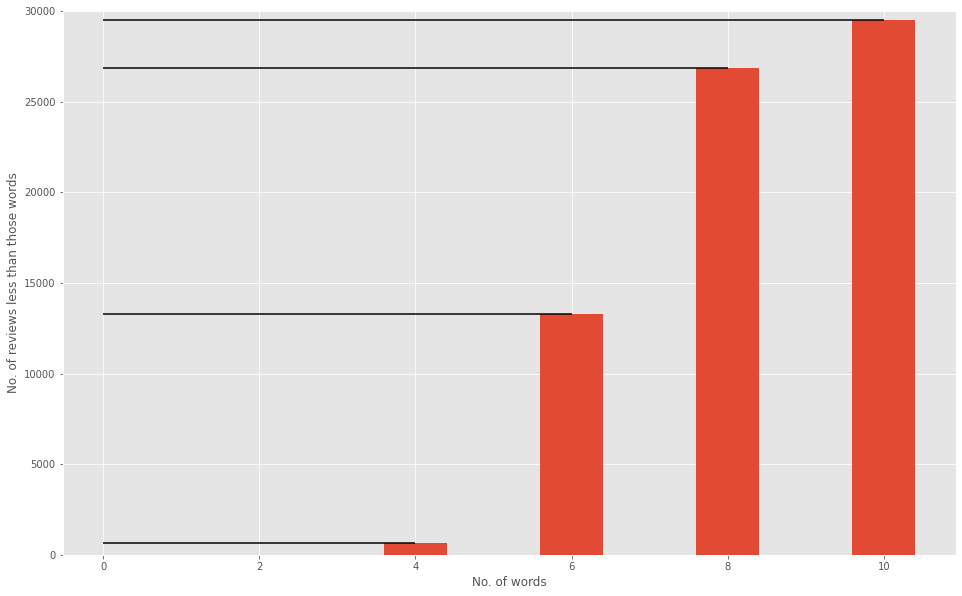

In [31]:
# Below list are to plot histogram
xval=[]
yval=[]

for review_len in range(4,12,2):  
  counter_r = 0
  for s in text_train_le:
    if len(s) < review_len:
      counter_r+=1  
  xval.append(review_len)
  yval.append(counter_r)
  print("Number of captions less than",review_len,"words :",counter_r)

#Plotting a histogram for visualization
plt.figure(figsize=(16,10))  #Increasing the figure size for easy visualization
plt.bar(xval,yval,align='center') #Histogram
plt.ylim(0,30000)  #Limiting y axis so that we can only focus on number of reviews more than 21000
plt.xlabel('No. of words')
plt.ylabel('No. of reviews less than those words')
for i in range(len(yval)):
    plt.hlines(yval[i],0,xval[i]) # Drawing the horizontal lines
plt.show()


## Pad Captions

In [0]:

seq_length = 8 #Derived from above analysis

def add_padding(oldcorpus, seq_length):
    corpus = copy.deepcopy(oldcorpus) #Performing a  deepcopy so that text_train_le, text_test_le does not get effected
    output = []
    for sentence in corpus:
      if len(sentence)>seq_length:
        output.append(sentence[:seq_length])  #Truncating the sentence if it is longer than seq_length
      else:
        for j in range(seq_length-len(sentence)): #Padding the sentence if it is smaller than seq_length
          sentence.append("<PAD>")
        output.append(sentence)
    return output

text_train_pad = add_padding(text_train_le,seq_length )
text_test_pad = add_padding(text_test_le,seq_length )



## Label Preprocessing

In [0]:
train_tags = []

for eachlab in train.Labels:
  label_tensor = [0]*output_dim
  for label in eachlab.split():
    label_tensor[label_to_index[int(label)]] = 1  #converting lavel to index of label
  train_tags.append(label_tensor)

train_tags = np.array(train_tags)

## Input for Bi-LSTM

In [0]:
train_caption_inputs = []
for ind in range(len(text_train_pad)):
  sentence = text_train_pad[ind]
  out_temp = []
  for word in sentence:
    bool_Wordfound = False
    wordindex = 0
    try:
      wordindex = word_dict[word]
      bool_Wordfound = True
    except:  #To handle scenarios where the word is not present in the dictionary
      bool_Wordfound = False
    if bool_Wordfound == True:
      out_temp.append(embedding_matrix[wordindex])
    else:
      out_temp.append([0]*EMBEDDING_DIM) #If the word is not found in word_dict then create a matrix with all zeros
  train_caption_inputs.append(out_temp)


test_caption_inputs = []
for ind in range(len(text_test_pad)):
  sentence = text_test_pad[ind]
  out_temp = []
  for word in sentence:
    bool_Wordfound = False
    wordindex = 0
    try:
      wordindex = word_dict[word]
      bool_Wordfound = True
    except:  #To handle scenarios where the word is not present in the dictionary
      bool_Wordfound = False
    if bool_Wordfound == True:
      out_temp.append(embedding_matrix[wordindex])
    else:
      out_temp.append([0]*EMBEDDING_DIM) #If the word is not found in word_dict then create a matrix with all zeros
  test_caption_inputs.append(out_temp)



## Training and Validation Split

In [35]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_caption_inputs,train_tags, test_size=VALIDATION_SET_SIZE)

print(f"Validation_Data Length: {len(X_train)}\nTrain_Data Length: {len(X_val)}")

Validation_Data Length: 27000
Train_Data Length: 3000


In [0]:

n_input = EMBEDDING_DIM
n_hidden = BILSTM_HIDDEN_DIM 
n_class = output_dim #number of unique labels
total_epoch = BILSTM_EPOCHS
learning_rate = BILSTM_LEARNINGRATE
seq_batch_size = BITSTM_BATCHSIZE 

## Data Loaders for BILSTM Model

In [0]:
from torch.utils.data import TensorDataset
train_caption_data = TensorDataset(torch.tensor(X_train,dtype= torch.float32), torch.tensor(y_train,dtype= torch.float32))

from torch.utils.data import DataLoader
train_caption_loader = DataLoader(dataset=train_caption_data, batch_size=seq_batch_size, shuffle=True)

from torch.utils.data import TensorDataset
val_caption_data = TensorDataset(torch.tensor(X_val,dtype= torch.float32), torch.tensor(y_val,dtype= torch.float32))

from torch.utils.data import DataLoader
val_caption_loader = DataLoader(dataset=val_caption_data, batch_size=seq_batch_size, shuffle=False)

## Build Model

In [0]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.1)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, x):
        lstm_out, (h_n,c_n) = self.lstm(x)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        log_output = z
        return log_output,hidden_out

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = [0.4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
class_weights = torch.FloatTensor(weights).to(device)
epoch_values = [] #Lists to store epoch values for later plotting
f1_scores = []  #Lists to store f1-values for later plotting

net = Net().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)#torch.nn.BCELoss()#nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
start_epoch = 0
best_f1 = np.NINF

## Load Pretrained Model (Optional)

In [0]:
path = PATH_TO_CODE_FOLDER+"algorithm/CaptionModel.pt"   #Load above saved model
try:
  net = torch.load(path)
except:
  net = torch.load(path, map_location=torch.device('cpu')) #Load into CPU if GPU is not available

## Training Model (Only for retraining)

Please only execute this section if you want to test with different hyperparameters, else the previously loaded model would suffice.

Info : model f1-score Improved from -inf to 0.78355529
Epoch: 1, Training loss: 0.15945, Validation loss: 0.10165, Validation f1-score: 0.784
Info : model f1-score Improved from 0.78355529 to 0.83502778
Epoch: 2, Training loss: 0.09433, Validation loss: 0.08926, Validation f1-score: 0.835
Info : model f1-score Improved from 0.83502778 to 0.84222249
Epoch: 3, Training loss: 0.08701, Validation loss: 0.08525, Validation f1-score: 0.842
Epoch: 4, Training loss: 0.08456, Validation loss: 0.08375, Validation f1-score: 0.835
Epoch: 5, Training loss: 0.08303, Validation loss: 0.08402, Validation f1-score: 0.842
Epoch: 6, Training loss: 0.08166, Validation loss: 0.08342, Validation f1-score: 0.841
Epoch: 7, Training loss: 0.08070, Validation loss: 0.08366, Validation f1-score: 0.828
Info : model f1-score Improved from 0.84222249 to 0.84326481
Epoch: 8, Training loss: 0.08011, Validation loss: 0.08358, Validation f1-score: 0.843
Info : model f1-score Improved from 0.84326481 to 0.84893466
Epoch

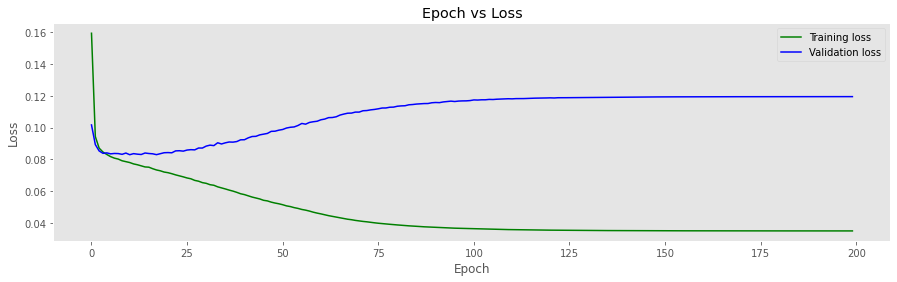

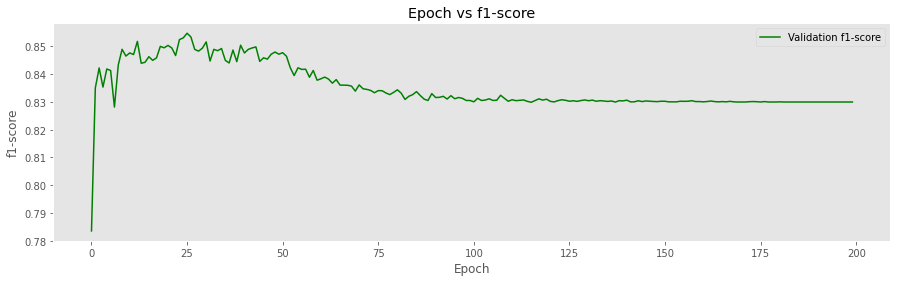

In [0]:
train_loss = []
val_loss = []
val_fone=[]


for epoch in range(start_epoch,total_epoch):
    start_time = time.time()
    net.train()
    running_loss = 0.0
    for idx1,(input_batch_torch, target_batch_torch) in enumerate(train_caption_loader):#tqdm(dataloaders_dict[phase],disable = True):
      input_batch_torch = input_batch_torch.to(device)
      target_batch_torch = target_batch_torch.to(device)
      optimizer.zero_grad()
      outputs,_ = net(input_batch_torch)
      loss = criterion(outputs, target_batch_torch)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
      optimizer.step()
      running_loss += loss.item() * input_batch_torch.size(0)
    trian_epoch_loss = running_loss / len(train_caption_loader.dataset)


    net.eval()
    running_loss = 0.0
    all_output_labels = []
    all_preds = []
    for idx1,(input_batch_torch, target_batch_torch) in enumerate(val_caption_loader):
      all_output_labels.extend(target_batch_torch.numpy().tolist())
      input_batch_torch = input_batch_torch.to(device)
      target_batch_torch = target_batch_torch.to(device)
      outputs,_ = net(input_batch_torch)
      all_preds.extend(torch.round(torch.sigmoid(outputs)).detach().cpu().numpy().tolist())
      loss = criterion(outputs, target_batch_torch)
      running_loss += loss.item() * input_batch_torch.size(0)

    val_epoch_loss = running_loss / len(val_caption_loader.dataset)
    val_f1_score = f1_score(y_true=all_output_labels, y_pred=all_preds, average='samples')#cal_f1score(all_preds, all_output_labels)
    
    if val_f1_score > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_f1_score))
      best_f1 = val_f1_score
      best_model_wts2 = copy.deepcopy(net.state_dict())

    epoch_values.append(epoch+1) #Store epoch value for plotting
    print('Epoch: %d, Training loss: %.5f, Validation loss: %.5f, Validation f1-score: %.3f' %(epoch + 1, trian_epoch_loss,val_epoch_loss, val_f1_score))
    train_loss.append(trian_epoch_loss)
    val_loss.append(val_epoch_loss)
    val_fone.append(val_f1_score)
    scheduler.step()

print('Finished Training of BiLSTM Model')

plt.figure(figsize=(15,4))
plt.plot(train_loss,label="Training loss",color="green")
plt.plot(val_loss,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(val_fone,label="Validation f1-score",color="green")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

net.load_state_dict(best_model_wts2)

## Extract Caption Features

In [0]:
net.eval()

input_batch_torch = torch.tensor(train_caption_inputs,dtype= torch.float32).to(device)
_,lstmhiddenstate = net(input_batch_torch) 

lstmhiddenstate = np.array(lstmhiddenstate.detach().cpu().numpy())

net.eval()

input_batch_torch = torch.tensor(test_caption_inputs,dtype= torch.float32).to(device)
_,test_lstmhiddenstate = net(input_batch_torch) 
test_lstmhiddenstate = np.array(test_lstmhiddenstate.detach().cpu().numpy())

# Combined Neural Network

## Input Creation

In [0]:
def make_inputs_for_combinedNN(imagefeatures,captionfeatures):
  inputs_x = []
  for i in range(len(imagefeatures)):
    inputs_x.append([*imagefeatures[i] ,*captionfeatures[i]])
  return np.array(inputs_x)

train_inputs_combinedNN = make_inputs_for_combinedNN(image_features,lstmhiddenstate)
test_inputs_combinedNN = make_inputs_for_combinedNN(test_image_features,test_lstmhiddenstate)

## Build Model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #Using GPU if available
class CombinedNN(nn.Module):
    def __init__(self):
        super(CombinedNN, self).__init__()
        self.linear1 = nn.Linear(train_inputs_combinedNN.shape[1], HIDDEN_COMBINEDNN,bias=True)
        self.linear2 = nn.Linear(HIDDEN_COMBINEDNN, output_dim,bias=True)
        self.lrelu = nn.ReLU(inplace=True)#nn.LeakyReLU(0.05, inplace=True)
        self.dropout = nn.Dropout(p=0.05)

    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout(out)
        out = self.lrelu(out)
        out = self.linear2(out)
        #out = self.linear2(hidden)
        return F.sigmoid(out),out 

learning_rate = LEARNINGRATE_COMBINEDNN

## Traning and Validation Split

In [44]:
from sklearn.model_selection import train_test_split
X_combinedNN_train, X_combinedNN_val, y_combinedNN_train, y_combinedNN_val = train_test_split(train_inputs_combinedNN,train_tags, test_size=VALIDATION_SET_SIZE)

print(f"Train Data Length: {len(X_combinedNN_train)}\nValidation Data Length: {len(X_combinedNN_val)}")


Train Data Length: 27000
Validation Data Length: 3000


## Data Loaders

In [0]:
from torch.utils.data import TensorDataset
train_combinedNN_data = TensorDataset(torch.tensor(X_combinedNN_train,dtype= torch.float32), torch.tensor(y_combinedNN_train,dtype= torch.float32))

from torch.utils.data import DataLoader
train_combinedNN_loader = DataLoader(dataset=train_combinedNN_data, batch_size=BATCHSIZE_COMBINEDNN, shuffle=True)

from torch.utils.data import TensorDataset
val_combinedNN_data = TensorDataset(torch.tensor(X_combinedNN_val,dtype= torch.float32), torch.tensor(y_combinedNN_val,dtype= torch.float32))

from torch.utils.data import DataLoader
val_combinedNN_loader = DataLoader(dataset=val_combinedNN_data, batch_size=BATCHSIZE_COMBINEDNN, shuffle=False)

In [0]:

weights = [0.5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]  #Penalize classes other than 1 more as the data is skewed
class_weights = torch.FloatTensor(weights).to(device)
epoch_values = []
train_loss = []
val_loss = []
val_fone=[]

combinednet = CombinedNN().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)#torch.nn.BCELoss()#nn.NLLLoss()
optimizer = optim.Adam(combinednet.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = PATIENCE)

start_epoch = 0
best_f1 = np.NINF

## Load Pretrained Model (Optional)

In [0]:
path = PATH_TO_CODE_FOLDER+"algorithm/CombinedNNModel.pt"   #Load above saved model
try:
  combinednet = torch.load(path)
except:
  combinednet = torch.load(path, map_location=torch.device('cpu')) #Load into CPU if GPU is not available

## Training Model (Only for retraining)

Please only execute this section if you want to test with different hyperparameters, else the previously loaded model would suffice.

Info : model f1-score Improved from -inf to 0.62047768
Epoch: 1, Training loss: 17.04505, Validation loss: 5.59768, Validation f1-score: 0.620
Info : model f1-score Improved from 0.62047768 to 0.82755212
Epoch: 2, Training loss: 3.39766, Validation loss: 0.67008, Validation f1-score: 0.828
Info : model f1-score Improved from 0.82755212 to 0.83235777
Epoch: 3, Training loss: 0.31317, Validation loss: 0.09289, Validation f1-score: 0.832
Info : model f1-score Improved from 0.83235777 to 0.86501070
Epoch: 4, Training loss: 0.08401, Validation loss: 0.07216, Validation f1-score: 0.865
Info : model f1-score Improved from 0.86501070 to 0.88587407
Epoch: 5, Training loss: 0.06964, Validation loss: 0.06327, Validation f1-score: 0.886
Info : model f1-score Improved from 0.88587407 to 0.89601837
Epoch: 6, Training loss: 0.06421, Validation loss: 0.06002, Validation f1-score: 0.896
Epoch: 7, Training loss: 0.06141, Validation loss: 0.06336, Validation f1-score: 0.895
Epoch: 8, Training loss: 0.061

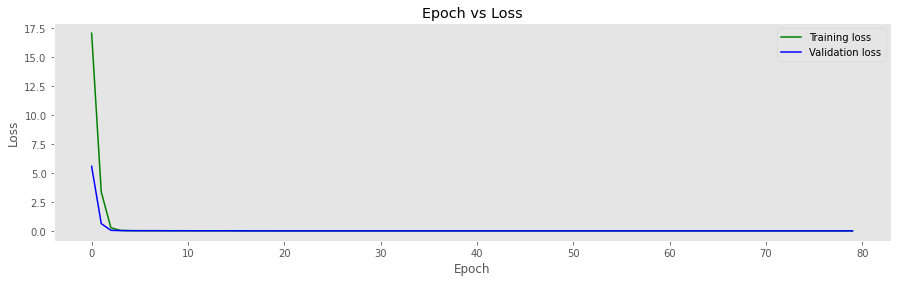

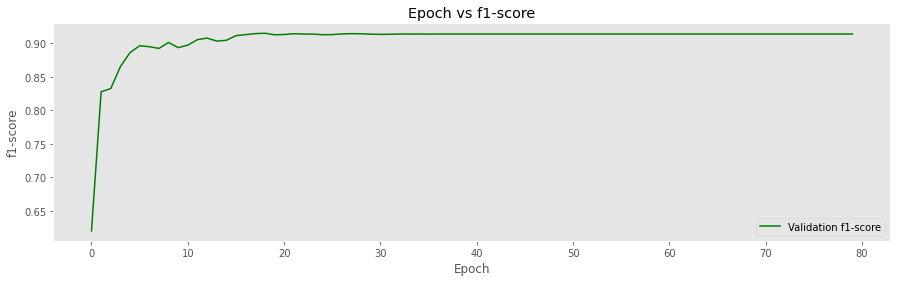

In [46]:

#ckp_path = "/content/SeqCheckPoint_59.pt"  #Uncomment to load a check point 
#net, optimizer, start_epoch = load_ckp(ckp_path, net, optimizer) #Uncomment to load a check point 

#Uncomment for debugging
#print("n_hidden",n_hidden)
#print("total_epoch",total_epoch)
#print("learning_rate",learning_rate)
#print("seq_batch_size",seq_batch_size)


for epoch in range(start_epoch,EPOCH_COMBINEDNN):
    #if epoch < 10:  #Uncomment during debugging
    #  print("Epoch "+str(epoch)+" Start Time:"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))  
    start_time = time.time()
    combinednet.train()
    running_loss = 0.0
    for idx1,(input_batch_torch, target_batch_torch) in enumerate(train_combinedNN_loader):#tqdm(dataloaders_dict[phase],disable = True):
      input_batch_torch = input_batch_torch.to(device)
      target_batch_torch = target_batch_torch.to(device)
      optimizer.zero_grad()
      _,outputs = combinednet(input_batch_torch)#outputs,_ = combinednet(input_batch_torch)
      loss = criterion(outputs, target_batch_torch)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(combinednet.parameters(), 0.5)
      optimizer.step()
      running_loss += loss.item() * input_batch_torch.size(0)
    trian_epoch_loss = running_loss / len(train_combinedNN_loader.dataset)


    combinednet.eval()
    all_output_labels = []
    all_preds = []
    running_loss = 0.0
    for idx1,(input_batch_torch, target_batch_torch) in enumerate(val_combinedNN_loader):
      all_output_labels.extend(target_batch_torch.numpy().tolist())
      input_batch_torch = input_batch_torch.to(device)
      target_batch_torch = target_batch_torch.to(device)
      _,outputs = combinednet(input_batch_torch)#outputs,_ = combinednet(input_batch_torch)
      all_preds.extend(torch.round(torch.sigmoid(outputs)).detach().cpu().numpy().tolist())

      loss = criterion(outputs, target_batch_torch)
      running_loss += loss.item() * input_batch_torch.size(0)

    val_epoch_loss = running_loss / len(val_combinedNN_loader.dataset)
    val_f1_score = f1_score(y_true=all_output_labels, y_pred=all_preds, average='samples')#cal_f1score(all_preds, all_output_labels)
    
    if val_f1_score > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_f1_score))
      best_f1 = val_f1_score
      best_model_wts3 = copy.deepcopy(combinednet.state_dict()) #Save weights of best f1

    epoch_values.append(epoch+1) #Store epoch value for plotting
    print('Epoch: %d, Training loss: %.5f, Validation loss: %.5f, Validation f1-score: %.3f' %(epoch + 1, trian_epoch_loss,val_epoch_loss, val_f1_score))
    train_loss.append(trian_epoch_loss)
    val_loss.append(val_epoch_loss)
    val_fone.append(val_f1_score)
		
    scheduler.step(val_epoch_loss)
  

print('Finished Training of Combined NN Model')

plt.figure(figsize=(15,4))
plt.plot(train_loss,label="Training loss",color="green")
plt.plot(val_loss,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(val_fone,label="Validation f1-score",color="green")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

combinednet.load_state_dict(best_model_wts3)

# Generate Predictions

In [51]:
combinednet.eval()

_,outputs = combinednet(torch.tensor(test_inputs_combinedNN,dtype= torch.float32).to(device))#outputs,_ = combinednet(input_batch_torch)
predictions = torch.round(torch.sigmoid(outputs)).detach().cpu().numpy().tolist()


predictions = np.array(predictions)

predicted_class_idx = []
for i in range(len(predictions)):         
    idx_list = np.where(predictions[i] ==1)#> np.percentile(predictions[i],PERCENTILE))
    #print(idx_list)
    label_list = [index_to_label[y] for y in idx_list[0]]  #converting index to labels
    predicted_class_idx.append(label_list)
	
	
test['Labels'] = predicted_class_idx
test['Labels'] = test['Labels'].apply(lambda x : ' '.join(map(str,list(x))))

test_tosubmit = test.drop("Caption",1)

OUTPUT_FILENAME = PATH_TO_CODE_FOLDER +'output/Predicted_labels'+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+'.txt'
test_tosubmit.to_csv(OUTPUT_FILENAME,index = False)

print("Predictions saved to",OUTPUT_FILENAME)

Predictions saved to /content/drive/My Drive/Code/output/Predicted_labels28-05-2020_06-05-11.txt
